In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# To ignore warnings (especially during model training)
warnings.filterwarnings("ignore")

In [2]:
pip install xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
data= pd.read_csv('ecommerce-fraud-dataset.csv')
data.head(3)

,Customer_ID,Customer_Age,Customer_Location,Customer_Tier,Purchase_History,Transaction_Amount,Payment_Method,Transaction_Status,Fraud,Product_Category,Device_Type,IP_Address,High_Risk_Countries,Mismatch_Between_IP_And_Location,Multiple_Transactions
0,CUST_156,25,India,new,17,260.81,PayPal,successful,0.0,home,desktop,244.166.103.86,0,0.0,0.0
1,CUST_13,20,UK,returning,20,190.22,debit card,successful,0.0,clothing,mobile,70.218.78.200,0,0.0,0.0
2,CUST_90,34,India,new,35,667.89,bank transfer,successful,1.0,sports,desktop,192.84.184.229,0,0.0,3.0


In [4]:
data.drop(columns=['IP_Address','Customer_ID','Device_Type'], inplace=True)
data.head(5)

,Customer_Age,Customer_Location,Customer_Tier,Purchase_History,Transaction_Amount,Payment_Method,Transaction_Status,Fraud,Product_Category,High_Risk_Countries,Mismatch_Between_IP_And_Location,Multiple_Transactions
0,25,India,new,17,260.81,PayPal,successful,0.0,home,0,0.0,0.0
1,20,UK,returning,20,190.22,debit card,successful,0.0,clothing,0,0.0,0.0
2,34,India,new,35,667.89,bank transfer,successful,1.0,sports,0,0.0,3.0
3,60,USA,returning,18,517.69,PayPal,successful,1.0,home,0,1.0,3.0
4,64,Germany,premium,40,233.10,PayPal,successful,0.0,clothing,0,0.0,2.0


In [5]:
data.shape

(800, 12)

In [6]:
data.isnull().sum()

Customer_Age                         0
Customer_Location                    0
Customer_Tier                       24
Purchase_History                     0
Transaction_Amount                   0
Payment_Method                       0
Transaction_Status                   0
Fraud                               24
Product_Category                     0
High_Risk_Countries                  0
Mismatch_Between_IP_And_Location    24
Multiple_Transactions               24
dtype: int64

In [7]:
data.duplicated().sum()

np.int64(0)

In [8]:
# Identify columns with missing values
missing_columns = data.columns[data.isnull().any()]

# Get the data types of these columns
missing_columns_dtypes = data[missing_columns].dtypes
print(missing_columns_dtypes)


Customer_Tier                        object
Fraud                               float64
Mismatch_Between_IP_And_Location    float64
Multiple_Transactions               float64
dtype: object


In [9]:
for i in data.select_dtypes(include='object').columns:
    data[i].fillna(data[i].mode()[0], inplace=True)


In [10]:
data['Mismatch_Between_IP_And_Location'].fillna(data['Mismatch_Between_IP_And_Location'].mode()[0], inplace=True)
data['Fraud'].fillna(data['Fraud'].mode()[0], inplace=True)


In [11]:
data['Multiple_Transactions'].fillna(data['Multiple_Transactions'].mean(), inplace=True)

In [12]:
data.isnull().sum()

Customer_Age                        0
Customer_Location                   0
Customer_Tier                       0
Purchase_History                    0
Transaction_Amount                  0
Payment_Method                      0
Transaction_Status                  0
Fraud                               0
Product_Category                    0
High_Risk_Countries                 0
Mismatch_Between_IP_And_Location    0
Multiple_Transactions               0
dtype: int64

In [13]:
for i in data.select_dtypes(include='object').columns:
    print(i,data[i].unique())


Customer_Location ['India' 'UK' 'USA' 'Germany' 'Other' 'Canada']
Customer_Tier ['new' 'returning' 'premium']
Payment_Method ['PayPal' 'debit card' 'bank transfer' 'credit card']
Transaction_Status ['successful' 'pending' 'failed']
Product_Category ['home' 'clothing' 'sports' 'other' 'electronics']


In [14]:
categorical_columns = []
for i in data.select_dtypes(include='object').columns:
    categorical_columns.append(i)
    
print(categorical_columns)

['Customer_Location', 'Customer_Tier', 'Payment_Method', 'Transaction_Status', 'Product_Category']


In [15]:
le = LabelEncoder()

for i in categorical_columns:
    data[i] = le.fit_transform(data[i])
    print(data[i].unique())

[2 4 5 1 3 0]
[0 2 1]
[0 3 1 2]
[2 1 0]
[2 0 4 3 1]


In [16]:
data.head(4)

,Customer_Age,Customer_Location,Customer_Tier,Purchase_History,Transaction_Amount,Payment_Method,Transaction_Status,Fraud,Product_Category,High_Risk_Countries,Mismatch_Between_IP_And_Location,Multiple_Transactions
0,25,2,0,17,260.81,0,2,0.0,2,0,0.0,0.0
1,20,4,2,20,190.22,3,2,0.0,0,0,0.0,0.0
2,34,2,0,35,667.89,1,2,1.0,4,0,0.0,3.0
3,60,5,2,18,517.69,0,2,1.0,2,0,1.0,3.0


In [17]:
scaler = MinMaxScaler()
data['Transaction_Amount'] = scaler.fit_transform(data[['Transaction_Amount']])
data.head(3)

,Customer_Age,Customer_Location,Customer_Tier,Purchase_History,Transaction_Amount,Payment_Method,Transaction_Status,Fraud,Product_Category,High_Risk_Countries,Mismatch_Between_IP_And_Location,Multiple_Transactions
0,25,2,0,17,0.252803,0,2,0.0,2,0,0.0,0.0
1,20,4,2,20,0.181439,3,2,0.0,0,0,0.0,0.0
2,34,2,0,35,0.664348,1,2,1.0,4,0,0.0,3.0


In [18]:
data['Fraud'].value_counts()

Fraud
0.0    648
1.0    152
Name: count, dtype: int64

In [19]:
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = data[data['Fraud'] == 0.0]
minority_class = data[data['Fraud'] == 1.0]

# Oversample the minority class
minority_oversampled = resample(
    minority_class,
    replace=True,  # Sample with replacement
    n_samples=len(majority_class),  # Match the majority class size
    random_state=42
)

# Combine the oversampled minority class with the majority class
data_resampled = pd.concat([majority_class, minority_oversampled])

# Shuffle the data
data = data_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(data['Fraud'].value_counts())


Fraud
0.0    648
1.0    648
Name: count, dtype: int64


In [20]:
data.shape

(1296, 12)

In [21]:
X = data.drop(columns='Fraud')
y = data['Fraud']

print(X.shape)
print(y.shape)

(1296, 11)
(1296,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [24]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Define models
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier()
}

# Train and evaluate models
accuracies = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate and store the accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Store both accuracies in the dictionary
    accuracies[name] = {"train": train_accuracy, "test": test_accuracy}
    
    print(f"{name} Train Accuracy: {train_accuracy:.4f}  Test Accuracy: {test_accuracy:.4f}")

# Display all model accuracies
print("\nModel Accuracies:")
for name, acc in accuracies.items():
    print(f"{name} - Train: {acc['train']:.4f}  Test: {acc['test']:.4f}")



SVM Train Accuracy: 0.7954  Test Accuracy: 0.8077
Random Forest Train Accuracy: 1.0000  Test Accuracy: 0.9654
Decision Tree Train Accuracy: 1.0000  Test Accuracy: 0.8923
XGBoost Train Accuracy: 1.0000  Test Accuracy: 0.9423
[LightGBM] [Info] Number of positive: 521, number of negative: 515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 1036, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502896 -> initscore=0.011583
[LightGBM] [Info] Start training from score 0.011583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

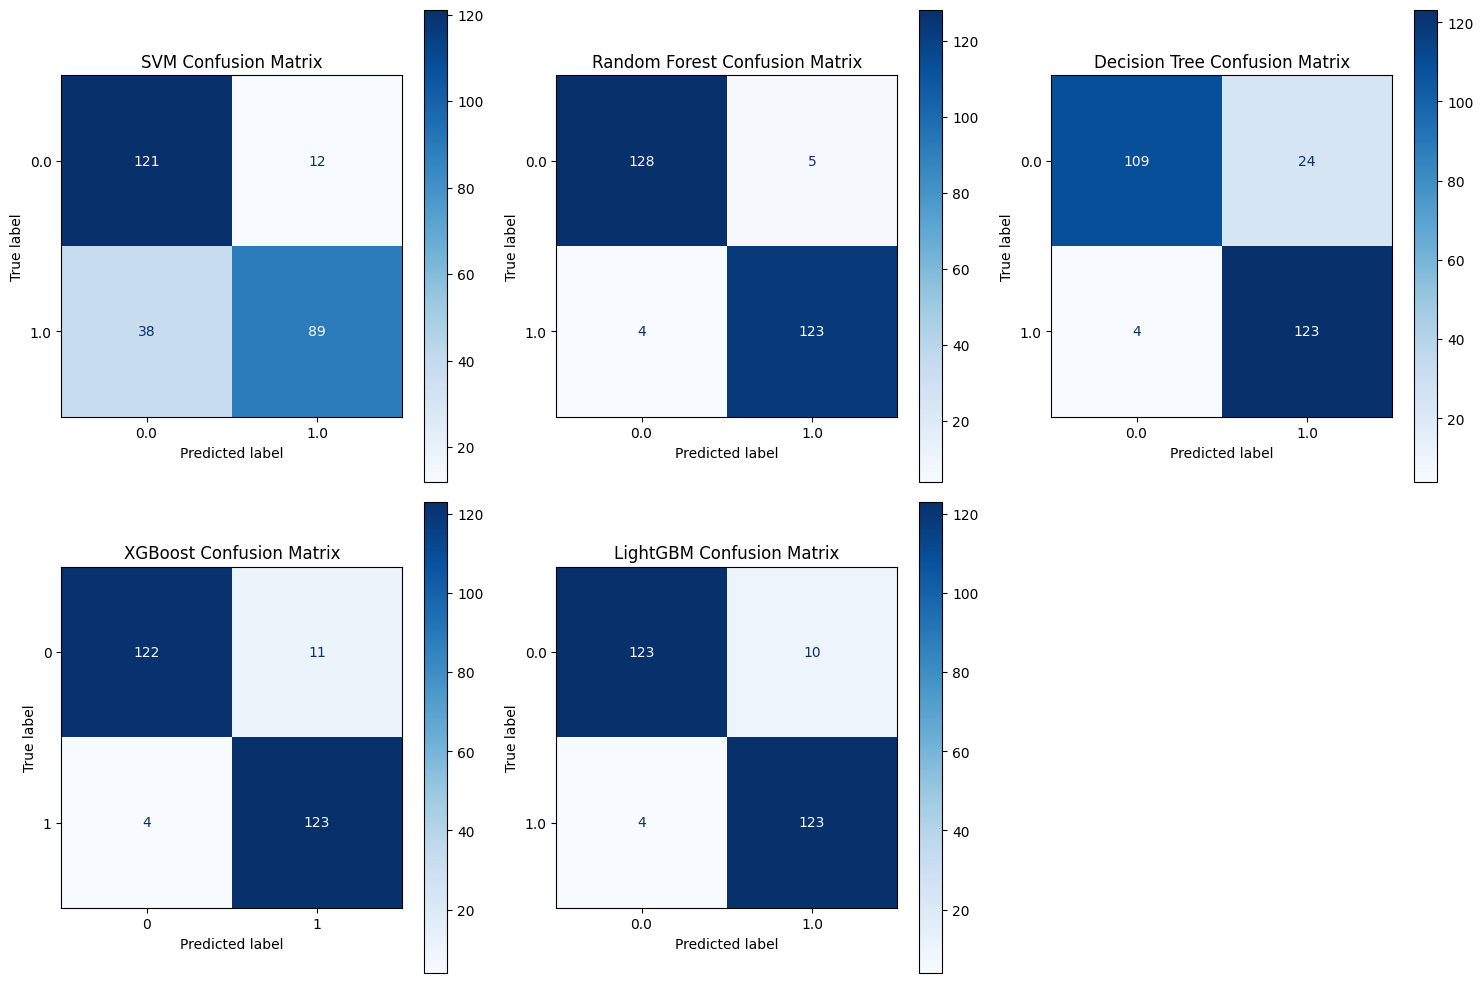

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a figure for all confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust rows and columns based on the number of models
axes = axes.flatten()  # Flatten to easily iterate over axes

# Generate confusion matrices for each model
for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_ if hasattr(model, 'classes_') else [0, 1])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=True)
    axes[idx].set_title(f"{name} Confusion Matrix")

# Hide unused subplots if any
for i in range(len(models), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
